In [70]:
import pandas as pd

In [71]:
senssor_data_2 = pd.read_csv("../data6.csv")

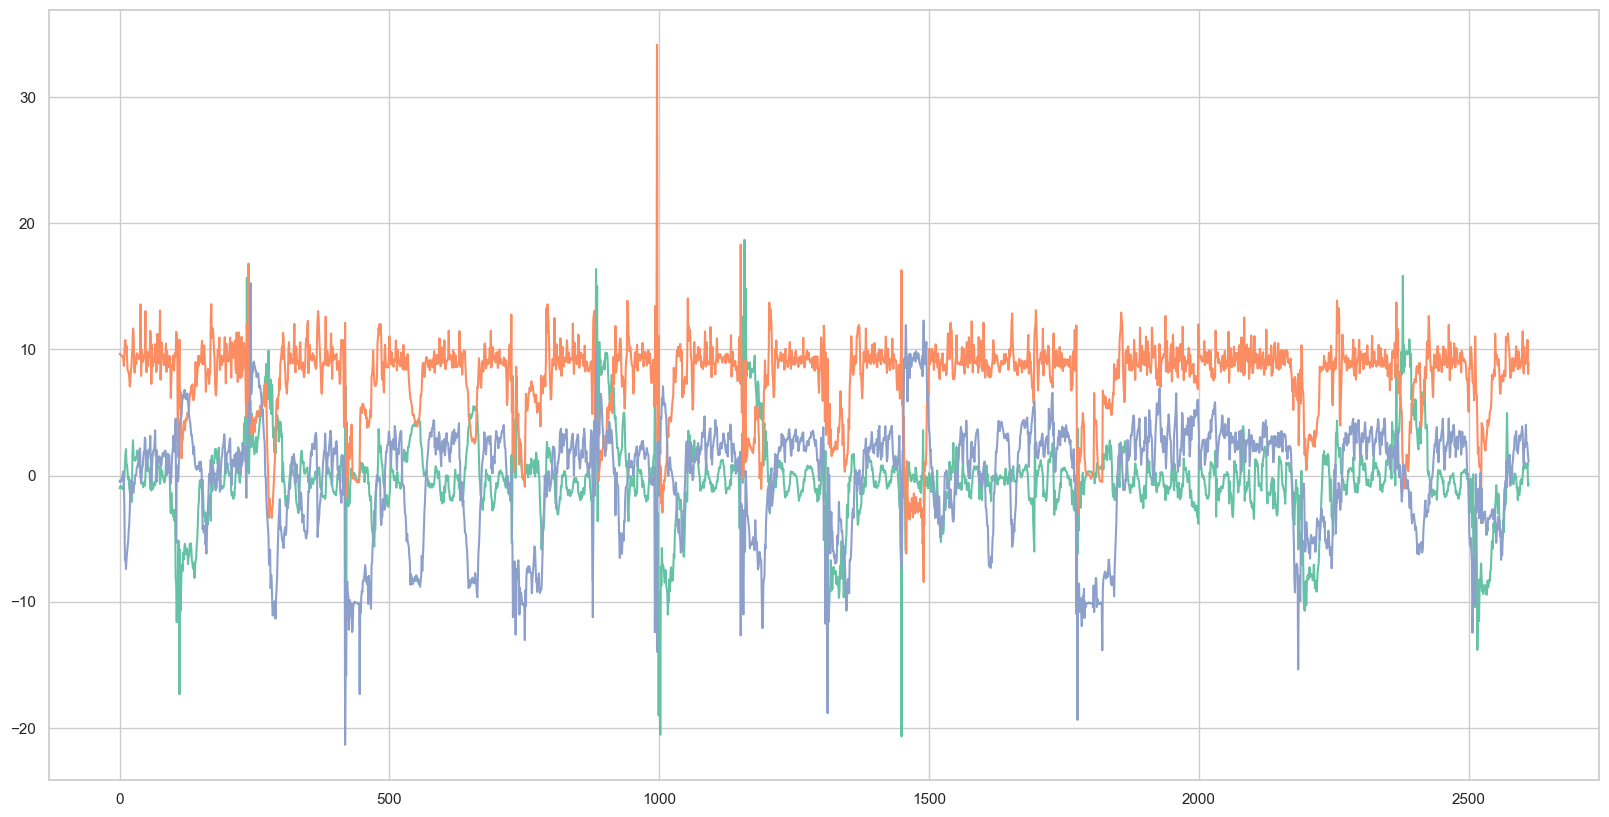

In [72]:
# plot sensor data, line plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_palette("Set2")

plt.figure(figsize=(20, 10))
plt.plot(senssor_data_2["ax"], label="ax")
plt.plot(senssor_data_2["ay"], label="ay")
plt.plot(senssor_data_2["az"], label="az")

In [73]:
# plot using plotly express
import plotly.express as px

# plot all three axis
fig = px.line(senssor_data_2, x=senssor_data_2.index, y=["ax", "ay", "az"])
fig.show()

In [74]:
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz

class MotionFeatureCalculator:
    def __init__(self, df, timestamp_col, accel_cols, time_unit="ms"):
        self.df = df
        self.timestamp_col = timestamp_col
        self.accel_cols = accel_cols
        self.time_unit = time_unit

    def calculate_time_interval(self):
        self.df[self.timestamp_col] = pd.to_datetime(self.df[self.timestamp_col])
        self.df["time_interval"] = (
            self.df[self.timestamp_col].diff().fillna(pd.Timedelta(seconds=0))
        )
        self.df["time_interval"] = self.df["time_interval"].dt.total_seconds()
        time_divisor = 1000 if self.time_unit == "ms" else 1
        self.df["time_interval"] /= time_divisor

    def calculate_velocity_displacement(self):
        for axis in self.accel_cols:
            velocity_col = f"v{axis[-1]}"
            self.df[velocity_col] = cumtrapz(
                self.df[axis], self.df["time_interval"], initial=0
            )

            displacement_col = f"d{axis[-1]}"
            self.df[displacement_col] = cumtrapz(
                self.df[velocity_col], self.df["time_interval"], initial=0
            )

    def calculate_angles(self):
        for axis1, axis2 in [("ax", "ay"), ("ay", "az"), ("az", "ax")]:
            angle_col = f"angle_{axis1[-1]}{axis2[-1]}"
            self.df[angle_col] = np.degrees(
                np.arctan2(self.df[axis1], self.df[axis2])
            )

    def calculate_g_force(self):
        self.df["g_force"] = np.sqrt(
            self.df["ax"] ** 2 + self.df["ay"] ** 2 + self.df["az"] ** 2
        )

    def calculate_jerk_orientation(self):
        self.df["jerk"] = (
            self.df["g_force"].diff().fillna(9.8) / self.df["time_interval"]
        )
        self.df["orientation_xy"] = np.degrees(
            np.arctan2(self.df["ay"], self.df["ax"])
        )
        self.df["orientation_yz"] = np.degrees(
            np.arctan2(self.df["az"], self.df["ay"])
        )
        self.df["orientation_zx"] = np.degrees(
            np.arctan2(self.df["ax"], self.df["az"])
        )

    def calculate_magnitudes(self):
        self.df["magnitude_acceleration"] = np.sqrt(
            self.df["ax"] ** 2 + self.df["ay"] ** 2 + self.df["az"] ** 2
        )
        self.df["magnitude_velocity"] = np.sqrt(
            self.df["vx"] ** 2 + self.df["vy"] ** 2 + self.df["vz"] ** 2
        )
        self.df["magnitude_displacement"] = np.sqrt(
            self.df["dx"] ** 2 + self.df["dy"] ** 2 + self.df["dz"] ** 2
        )

    def calculate_impact_detection(self):
        self.df["impact_detection"] = self.df["jerk"].apply(
            lambda x: 1 if x > 75000 else 0
        )

    def calculate_all_features(self):
        self.calculate_time_interval()
        self.calculate_velocity_displacement()
        self.calculate_angles()
        self.calculate_g_force()
        self.calculate_jerk_orientation()
        self.calculate_magnitudes()
        self.calculate_impact_detection()
        return self.df


In [75]:
calculator = MotionFeatureCalculator(senssor_data_2, 'timestamp_local', ['ax', 'ay', 'az'])
updated_df = calculator.calculate_all_features()

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_95472/4070250852.py:24: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_95472/4070250852.py:29: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_95472/4070250852.py:24: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_95472/4070250852.py:29: DeprecationWarning:

'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0

/var/folders/z0/17ykh1n151x8y8rfk6dfkv500000gn/T/ipykernel_95472

In [76]:
# updated_df = calculate_motion_features(
#     senssor_data_2, "timestamp_local", ["ax", "ay", "az"]
# )
# updated_df.head()

In [77]:
updated_df.head()

timestamp            timestamp_local        ax        ay        az  \
0    2554091 2024-02-06 10:30:55.165012 -0.997843  9.652991 -0.485760   
1    2554167 2024-02-06 10:30:55.239608 -1.009807  9.667349 -0.380472   
2    2554244 2024-02-06 10:30:55.314809 -0.815982  9.571632 -0.502511   
3    2554321 2024-02-06 10:30:55.389846 -0.945199  9.571632 -0.459438   
4    2554397 2024-02-06 10:30:55.464786 -0.904519  9.480701 -0.397223   

   fall_state  time_interval        vx            dx        vy  ...  \
0           0       0.000000  0.000000  0.000000e+00  0.000000  ...   
1           0       0.000075 -0.000075 -2.792924e-09  0.000721  ...   
2           0       0.000075 -0.000075 -2.838394e-09  0.000726  ...   
3           0       0.000075 -0.000075 -2.826035e-09  0.000725  ...   
4           0       0.000075 -0.000075 -2.818736e-09  0.000724  ...   

     angle_zx   g_force         jerk  orientation_xy  orientation_yz  \
0 -154.042693  9.716578          inf       95.901780       -2.880823   
1 -159.354732  9.727389   144.928120       95.963231       -2.253794   
2 -148.373752  9.619485 -1434.880800       94.872684       -3.005270   
3 -154.076728  9.629155   128.874409       95.639674       -2.748088   
4 -156.291154  9.532032 -1296.008593       95.449886       -2.399177   

   orientation_zx  magnitude_acceleration  magnitude_velocity  \
0     -115.957307                9.716578            0.000000   
1     -110.645268                9.727389            0.000725   
2     -121.626248                9.619485            0.000731   
3     -115.923272                9.629155            0.000729   
4     -113.708846                9.532032            0.000729   

   magnitude_displacement  impact_detection  
0            0.000000e+00                 1  
1            2.704889e-08                 0  
2            2.748941e-08                 0  
3            2.736965e-08                 0  
4            2.729893e-08                 0  

[5 rows x 25 columns]

In [78]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               2612 non-null   int64         
 1   timestamp_local         2612 non-null   datetime64[ns]
 2   ax                      2612 non-null   float64       
 3   ay                      2612 non-null   float64       
 4   az                      2612 non-null   float64       
 5   fall_state              2612 non-null   int64         
 6   time_interval           2612 non-null   float64       
 7   vx                      2612 non-null   float64       
 8   dx                      2612 non-null   float64       
 9   vy                      2612 non-null   float64       
 10  dy                      2612 non-null   float64       
 11  vz                      2612 non-null   float64       
 12  dz                      2612 non-null   float64 

In [79]:
# plot updated_df with all columns as line plot using polotlöy express
# these are the columns timestamp	ax	ay	az	recorded_at	time_interval	vx	dx	angle_xy	angle_yz	angle_zx	g_force	vy	dy	vz	dz

import plotly.express as px

# columns = timestamp	ax	ay	az	recorded_at	time_interval	vx	dx	angle_xy	angle_yz	angle_zx	g_force	vy	dy	vz	dz
fig = px.line(
    updated_df,
    x=updated_df.index,
    y=[
        "ax",
        "ay",
        "az",
        "vx",
        "vy",
        "vz",
        "dx",
        "dy",
        "dz",
        "angle_xy",
        "angle_yz",
        "angle_zx",
        "g_force",
        "jerk",
        "orientation_xy",
        "orientation_yz",
        "orientation_zx",
        "magnitude_acceleration",
        "magnitude_velocity",
        "magnitude_displacement",
        "impact_detection",
    ],
)

# add slider to plot
fig.update_xaxes(rangeslider_visible=True)

In [80]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplots with 7 rows
fig = make_subplots(rows=10, cols=1, shared_xaxes=True)

# Acceleration
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['ax'], name='ax'), row=1, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['ay'], name='ay'), row=1, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['az'], name='az'), row=1, col=1)

# Fall State
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['fall_state'], name='fall_state'), row=2, col=1)

# Velocity
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vx'], name='vx'), row=3, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vy'], name='vy'), row=3, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['vz'], name='vz'), row=3, col=1)

# Displacement
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dx'], name='dx'), row=4, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dy'], name='dy'), row=4, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['dz'], name='dz'), row=4, col=1)

# Angles
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_xy'], name='angle_xy'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_yz'], name='angle_yz'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['angle_zx'], name='angle_zx'), row=5, col=1)

# Force
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['g_force'], name='g_force'), row=6, col=1)

# Jerk
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['jerk'], name='jerk'), row=7, col=1)

# Force and Orientation
# fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['g_force'], name='g_force'), row=5, col=1)
# fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['jerk'], name='jerk'), row=5, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_xy'], name='orientation_xy'), row=8, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_yz'], name='orientation_yz'), row=8, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['orientation_zx'], name='orientation_zx'), row=8, col=1)

# Magnitudes
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_acceleration'], name='magnitude_acceleration'), row=9, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_velocity'], name='magnitude_velocity'), row=9, col=1)
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['magnitude_displacement'], name='magnitude_displacement'), row=9, col=1)

# Impact Detection
fig.add_trace(go.Scatter(x=updated_df.index, y=updated_df['impact_detection'], name='impact_detection'), row=10, col=1)

# add title for row 
# list of titles
titles = ["Acceleration", "Fall State", "Velocity", "Displacement", "Angles", "Force", "Jerk", "Force and Orientation", "Magnitudes", "Impact Detection"]
for i, title in enumerate(titles):
    fig.update_yaxes(title_text=title, row=i+1, col=1)

# Update layout
fig.update_layout(height=1400, width=1200, title_text="Sensor Data Detailed View")
# fig.update_xaxes(rangeslider_visible=True)

# Show plot
fig.show()



In [81]:
# jerk value at point 997
jerk_at_997 = updated_df['jerk'][996]
print(jerk_at_997)

370648.54473115917


In [82]:
# save updated_df as csv file
# updated_df.to_csv("data.csv")

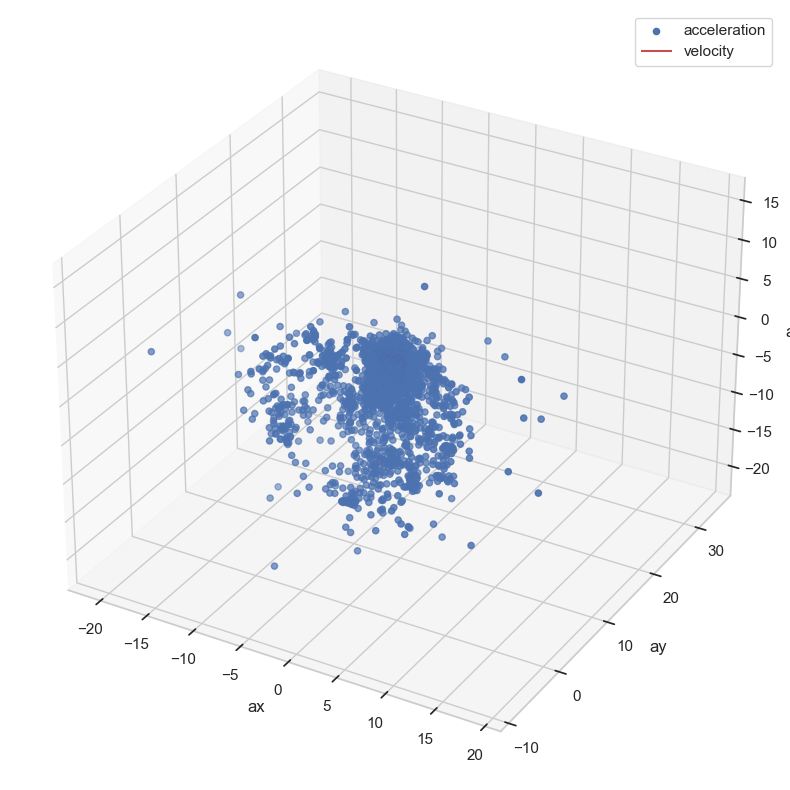

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# plot 3d plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    updated_df["ax"],
    updated_df["ay"],
    updated_df["az"],
    color="b",
    label="acceleration",
)

ax.quiver(
    updated_df["ax"],
    updated_df["ay"],
    updated_df["az"],
    updated_df["vx"],
    updated_df["vy"],
    updated_df["vz"],
    color="r",
    label="velocity",
    length=0.1,
)

ax.set_xlabel("ax")
ax.set_ylabel("ay")
ax.set_zlabel("az")

ax.legend()

plt.show()

In [84]:
# import numpy as np
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         super().__init__((0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def do_3d_projection(self, renderer=None):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

#         return np.min(zs)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
# a = Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict)
# ax.add_artist(a)
# a = Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict)
# ax.add_artist(a)
# a = Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict)
# ax.add_artist(a)

# ax.text(0.0, 0.0, -0.1, r'$o$')
# ax.text(1.1, 0, 0, r'$x$')
# ax.text(0, 1.1, 0, r'$y$')
# ax.text(0, 0, 1.1, r'$z$')

# ax.view_init(azim=20, elev=10)
# plt.show()

In [85]:
data_with_g_force_bigger_than_10 = updated_df[updated_df["g_force"] > 12]
data_with_g_force_bigger_than_10

timestamp            timestamp_local         ax         ay         az  \
10      2554856 2024-02-06 10:30:55.929791   0.768124  10.607761  -6.688178   
11      2554932 2024-02-06 10:30:56.004672   1.742037  10.746551  -6.499138   
12      2555009 2024-02-06 10:30:56.079077   2.098580   9.753493  -7.408443   
13      2555085 2024-02-06 10:30:56.154560   0.753766  10.284719  -6.616391   
25      2556003 2024-02-06 10:30:57.068974   2.802095  11.665427  -1.318492   
...         ...                        ...        ...        ...        ...   
2508    2745960 2024-02-06 10:34:07.027817   0.095716   7.319906  -9.911426   
2509    2746037 2024-02-06 10:34:07.102764  -9.353878   7.312727 -10.287112   
2512    2746266 2024-02-06 10:34:07.342386 -10.421115  11.028913 -10.258397   
2516    2746572 2024-02-06 10:34:07.642734 -13.819044   4.103837  -1.308921   
2519    2746801 2024-02-06 10:34:07.867702 -11.548175   1.069630  -3.381179   

      fall_state  time_interval        vx            dx        vy  ...  \
10             0       0.000076 -0.000078 -2.864223e-09  0.000737  ...   
11             0       0.000075 -0.000079 -2.793983e-09  0.000728  ...   
12             0       0.000074 -0.000080 -2.756306e-09  0.000723  ...   
13             0       0.000075 -0.000078 -2.841297e-09  0.000734  ...   
25             0       0.000074 -0.000086 -3.952222e-09  0.000713  ...   
...          ...            ...       ...           ...       ...  ...   
2508           1       0.000075  0.000284 -1.361227e-08  0.000896  ...   
2509           1       0.000075  0.000285 -1.363732e-08  0.000895  ...   
2512           1       0.000090  0.000191 -1.013547e-08  0.001028  ...   
2516           1       0.000075  0.000315 -1.382099e-08  0.000888  ...   
2519           1       0.000075  0.000317 -1.388542e-08  0.000888  ...   

        angle_zx    g_force          jerk  orientation_xy  orientation_yz  \
10    -83.448402  12.563691  36330.988107       85.858358      -32.231371   
11    -74.995080  12.679189   1542.419635       80.792334      -31.164083   
12    -74.184233  12.426573  -3395.158158       77.857253      -37.219149   
13    -83.500653  12.252356  -2308.025657       85.808292      -32.754088   
25    -25.198768  12.069480  24018.447374       76.493154       -6.448526   
...          ...        ...           ...             ...             ...   
2508  -89.446702  12.321791 -37358.614135       89.250833      -53.552943   
2509 -132.279659  15.709732  45204.491686      141.982217      -54.592389   
2512 -135.450826  18.315875  93758.267335      133.376926      -42.927025   
2516 -174.589166  14.474831  70315.123330      163.460175      -17.690105   
2519 -163.680547  12.080431  45351.766126      174.708175      -72.445327   

      orientation_zx  magnitude_acceleration  magnitude_velocity  \
10        173.448402               12.563691            0.000742   
11        164.995080               12.679189            0.000732   
12        164.184233               12.426573            0.000727   
13        173.500653               12.252356            0.000738   
25        115.198768               12.069480            0.000719   
...              ...                     ...                 ...   
2508      179.446702               12.321791            0.001061   
2509     -137.720341               15.709732            0.001061   
2512     -134.549174               18.315875            0.001109   
2516      -95.410834               14.474831            0.001042   
2519     -106.319453               12.080431            0.001042   

      magnitude_displacement  impact_detection  
10              2.788269e-08                 0  
11              2.722002e-08                 0  
12              2.687263e-08                 0  
13              2.766261e-08                 0  
25              2.602758e-08                 0  
...                      ...               ...  
2508            3.879589e-08                 0  
2509            3.875858e-08      

In [86]:
##n plot just the g_force column as a line plot
# use plotly express
import plotly.express as px

fig = px.line(updated_df, x=updated_df.index, y=["jerk"])
fig.show()

In [87]:
# 3 d scatter plot of ax, ay, az using plotly express
import plotly.express as px

fig = px.scatter_3d(updated_df, x="ax", y="ay", z="az", color="g_force")
fig.show()

In [88]:
# display correlation heatmapn of updated_df using plotly express

import plotly.express as px

fig = px.imshow(updated_df.corr())
fig.show()

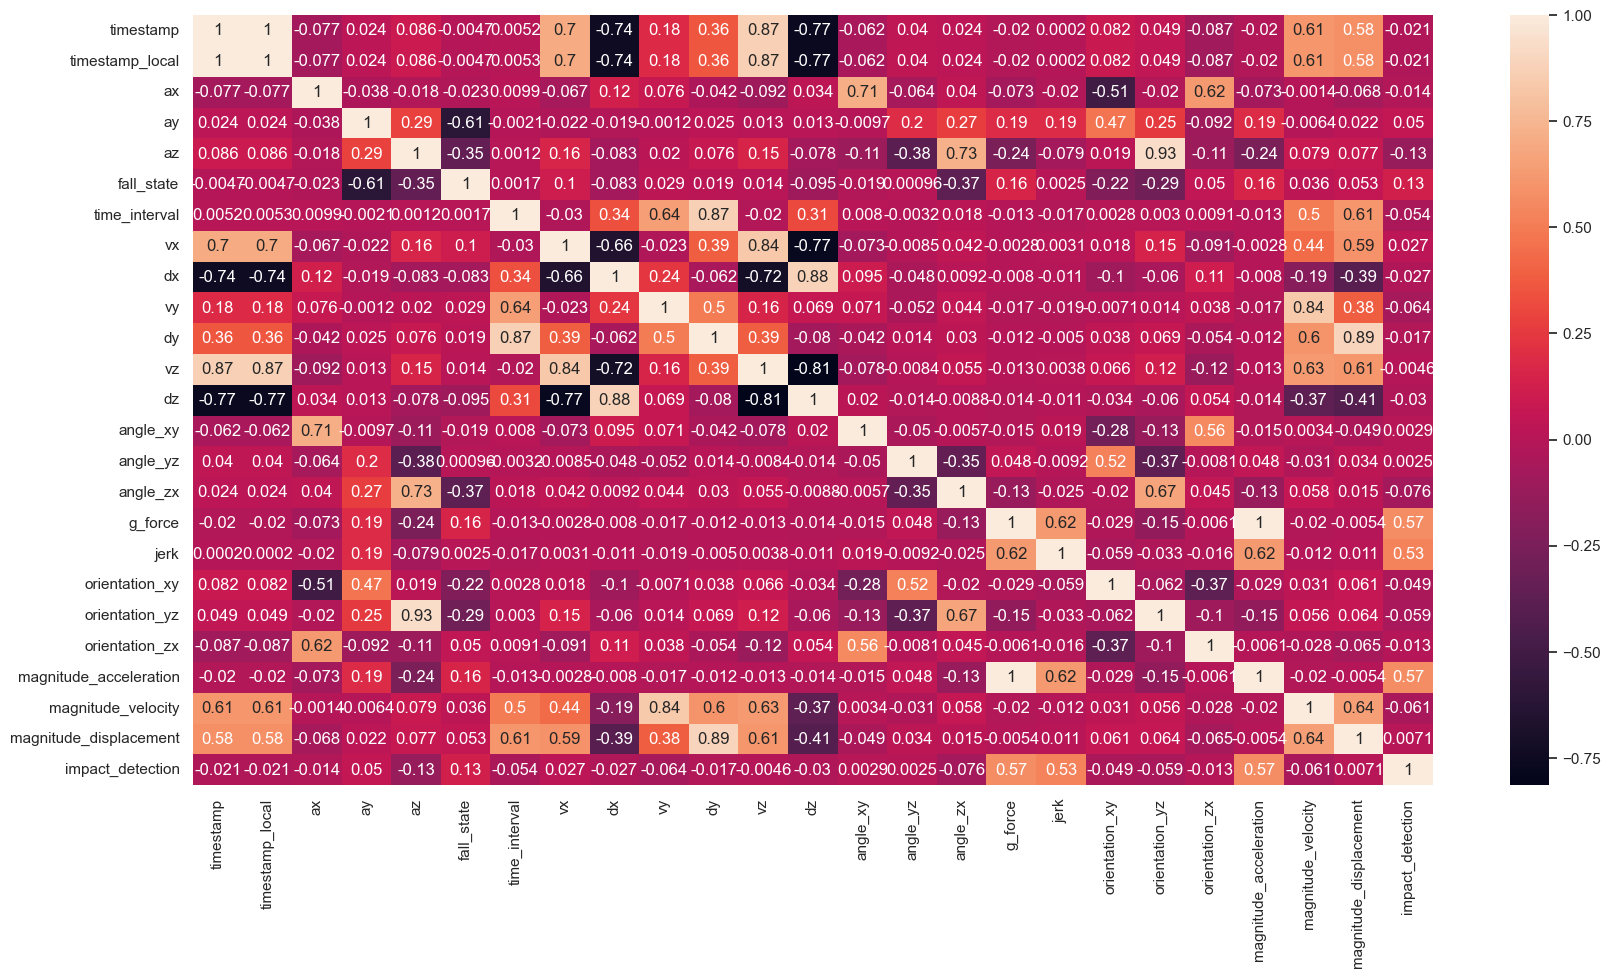

In [89]:
# correlation heatmap using seaborn
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_palette("Set2")

plt.figure(figsize=(20, 10))
sns.heatmap(updated_df.corr(), annot=True)
plt.show()


In [90]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               2612 non-null   int64         
 1   timestamp_local         2612 non-null   datetime64[ns]
 2   ax                      2612 non-null   float64       
 3   ay                      2612 non-null   float64       
 4   az                      2612 non-null   float64       
 5   fall_state              2612 non-null   int64         
 6   time_interval           2612 non-null   float64       
 7   vx                      2612 non-null   float64       
 8   dx                      2612 non-null   float64       
 9   vy                      2612 non-null   float64       
 10  dy                      2612 non-null   float64       
 11  vz                      2612 non-null   float64       
 12  dz                      2612 non-null   float64 

In [91]:
# boxplot of g_force column
import plotly.express as px

fig = px.box(updated_df, y="jerk")
fig.show()

In [92]:
# plot impact detection column as a line plot
import plotly.express as px

fig = px.line(updated_df, x=updated_df.index, y=["impact_detection"])
fig.show()

In [93]:
# display only jerk column as a line plot
import plotly.express as px

fig = px.line(updated_df, x=updated_df.index, y=["jerk"])
fig.show()

In [94]:
updated_df

timestamp            timestamp_local        ax         ay        az  \
0       2554091 2024-02-06 10:30:55.165012 -0.997843   9.652991 -0.485760   
1       2554167 2024-02-06 10:30:55.239608 -1.009807   9.667349 -0.380472   
2       2554244 2024-02-06 10:30:55.314809 -0.815982   9.571632 -0.502511   
3       2554321 2024-02-06 10:30:55.389846 -0.945199   9.571632 -0.459438   
4       2554397 2024-02-06 10:30:55.464786 -0.904519   9.480701 -0.397223   
...         ...                        ...       ...        ...       ...   
2607    2753534 2024-02-06 10:34:14.602688  0.681979   9.449594  2.574769   
2608    2753610 2024-02-06 10:34:14.677896  0.691550   9.301233  2.596305   
2609    2753687 2024-02-06 10:34:14.752150  1.000236  10.758514  2.172760   
2610    2753763 2024-02-06 10:34:14.828111 -0.813589   8.049743  1.533854   
2611    2753839 2024-02-06 10:34:14.902708 -0.634121   8.930333  1.093559   

      fall_state  time_interval        vx            dx        vy  ...  \
0              0       0.000000  0.000000  0.000000e+00  0.000000  ...   
1              0       0.000075 -0.000075 -2.792924e-09  0.000721  ...   
2              0       0.000075 -0.000075 -2.838394e-09  0.000726  ...   
3              0       0.000075 -0.000075 -2.826035e-09  0.000725  ...   
4              0       0.000075 -0.000075 -2.818736e-09  0.000724  ...   
...          ...            ...       ...           ...       ...  ...   
2607           0       0.000075  0.000290 -1.378453e-08  0.000867  ...   
2608           0       0.000075  0.000290 -1.378133e-08  0.000867  ...   
2609           0       0.000074  0.000289 -1.405771e-08  0.000858  ...   
2610           0       0.000076  0.000289 -1.356375e-08  0.000874  ...   
2611           0       0.000075  0.000290 -1.395923e-08  0.000862  ...   

        angle_zx    g_force          jerk  orientation_xy  orientation_yz  \
0    -154.042693   9.716578           inf       95.901780       -2.880823   
1    -159.354732   9.727389  1.449281e+02       95.963231       -2.253794   
2    -148.373752   9.619485 -1.434881e+03       94.872684       -3.005270   
3    -154.076728   9.629155  1.288744e+02       95.639674       -2.748088   
4    -156.291154   9.532032 -1.296009e+03       95.449886       -2.399177   
...          ...        ...           ...             ...             ...   
2607   75.164738   9.817809 -2.728865e+03       85.872111       15.241612   
2608   75.085018   9.681528 -1.812050e+03       85.747860       15.596310   
2609   65.280906  11.021206  1.804184e+04       84.688393       11.417723   
2610  117.942427   8.234864 -3.668122e+04       95.771295       10.788212   
2611  120.108103   9.019359  1.051643e+04       94.061613        6.981366   

      orientation_zx  magnitude_acceleration  magnitude_velocity  \
0        -115.957307                9.716578            0.000000   
1        -110.645268                9.727389            0.000725   
2        -121.626248                9.619485            0.000731   
3        -115.923272                9.629155            0.000729   
4        -113.708846                9.532032            0.000729   
...              ...                     ...                 ...   
2607       14.835262                9.817809            0.000992   
2608       14.914982                9.681528            0.000993   
2609       24.719094               11.021206            0.000983   
2610      -27.942427                8.234864            0.000998   
2611      -30.108103                9.019359            0.000988   

      magnitude_displacement  impact_detection  
0               0.000000e+00                 1  
1               2.704889e-08                 0  
2               2.748941e-08                 0  
3               2.736965e-08                 0  
4               2.729893e-08                 0  
...                      ...               ...  
2607            3.928513e-08                 0  
2608            3.929027e-08                 0  
2609     